# Chaotic Advection and Blinking Vortices

In this notebook we investigate the behavior of two vortices in a fluidic system and how this system evolves chaotically given that these vortices blink. I.e. when the sign of the vortices change discretly over time.

## Construction of Ordinary Differential Equations

The equation for the dipole system can be framed in terms of the velocity vector where we denote:

$$\boldsymbol{u} = (u,v)$$

With the scalar $u$ and $v$ functions given by:

$$u(x,y) = \frac{- \alpha y}{\left(x-\beta\right)^2 + y^2} - \frac{\alpha y}{\left(x+\beta\right)^2 + y^2}$$

$$v(x,y) = \frac{\alpha \left(x-\beta\right)}{\left(x-\beta\right)^2 + y^2} + \frac{\alpha \left(x+\beta\right)}{\left(x+\beta\right)^2 + y^2}$$

To solve for the position vector:

$$\boldsymbol{x} = (x,y)$$

One would simply integrate over $\boldsymbol{u}$ as such:

$$\frac{d\boldsymbol{x}}{dt} = \boldsymbol{u}$$

## Integration with Non-Blinking Vortices

To integrate the equations without blinking vortices, we assume that the fluid is in steady state. That is, there is no explicit time dependence in the above ODEs. Such assumptions will change when we include blinking vortices.

To complete the integration in python, we use SciPy's odeint and thus will need to import alongside NumPy etc.

In [297]:
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [319]:
# We define the steady state ODEs with parameters alpha and beta
def steadyStateODEs(diff_array,t,alpha,beta):
    x = diff_array[0]
    y = diff_array[1]
    
    # These equations are as above
    u = (- alpha * y)/((x-beta)**2 + y**2) - (alpha * y)/((x+beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2) - (alpha * (x+beta))/((x+beta)**2 + y**2)
    
    return [u, v]

Below we define our time space to be of 10 seconds, with 100 points per second. This will give a fairly accurate numerical simulation. However, as we decrease the numbe of points, the simulation will no longer remain as accurate.

In [299]:
t = np.linspace(0,10,1000)

## Demonstrating Circular Paths

By integration of these ODEs we may show that given an initial particle position, paths follow regular orbits in the flow field. Namely, that if we plot the $x$ and $y$ vlaues, we should get ellipses. To demonstrate this, we choose a set of 4 initial positions in each of the four quadrants of the cartesian plane.

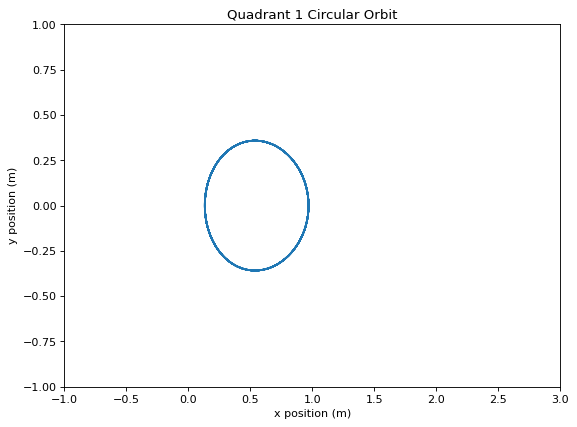

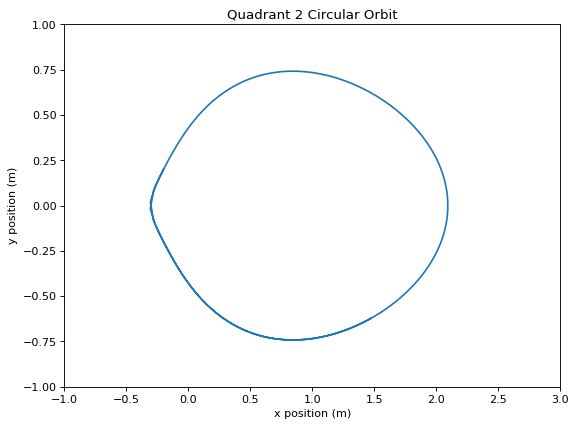

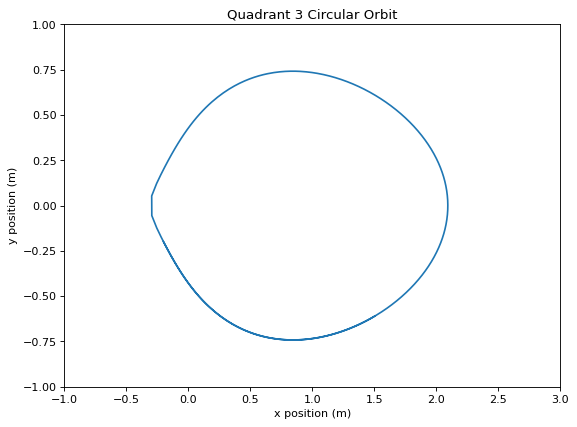

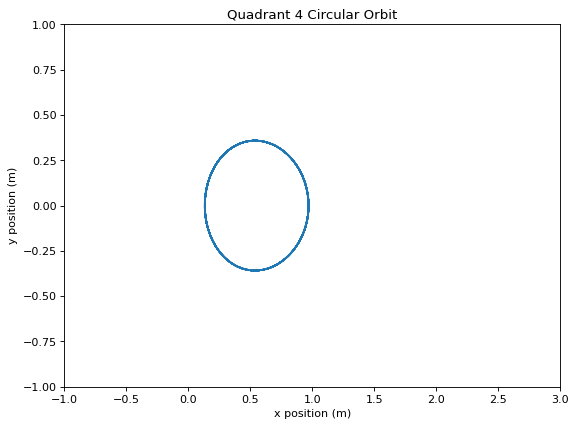

In [300]:
initialPositionQs = [[0.2,0.2], [-0.2,0.2], [-0.2,-0.2], [0.2,-0.2]]
quadrantResults = []

for initialPosition in initialPositionQs:
    quadrantResults.append(odeint(steadyStateODEs, initialPosition, t, args=(1,0.4)))

for i, quadrantResult in enumerate(quadrantResults):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(quadrantResult[:,0], quadrantResult[:,1])
    plt.title(f"Quadrant {i+1} Circular Orbit")
    plt.xlim(-1,3)
    plt.ylim(-1,1)
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.show()

As we can see there are clearly obrital paths. However, these plots are not entirely rigorous, thus we wish to plot the vector field itself to see the motion more clearly.

## Plotting Vector Field

We wish to plot the vector field of the ODEs in order to get a better sense of the circular orbits which the particles take. We do so by iterating over a mesh grid of initial $x$ and $y$ positions to get the velocity vectors and then plotting some paths as well. To do so, we first write a function to find $u$ and $v$ at a particular $(x,y)$.

In [301]:
def calculateVelocities(x,y,alpha,beta):
    return (- alpha * y)/((x-beta)**2 + y**2) - (alpha * y)/((x+beta)**2 + y**2), \
            (alpha * (x-beta))/((x-beta)**2 + y**2) - (alpha * (x+beta))/((x+beta)**2 + y**2)

In [328]:
def plotVectorField(ODE, iterations, temporalLength, xlim, ylim, color, identifier, includeArrows):
    
    t = np.linspace(0,temporalLength, iterations)
    
    # We plot more paths than vectors
    xPaths = np.linspace(-xlim,xlim,25)
    yPaths = np.linspace(-ylim,ylim,25)

    # We don't include x and y values between that of -0.1 and 0.1 as these explode close to the vortices.
    xVectors = np.concatenate((np.linspace(-xlim,-0.1,10),np.linspace(0.1,xlim,10)), axis=0)
    yVectors = np.concatenate((np.linspace(-ylim,-0.1,10),np.linspace(0.1,ylim,10)), axis=0)

    # Create a mishgrid for later plotting
    X,Y = np.meshgrid(xVectors, yVectors)

    U = []
    V = []

    pathGrid = []

    # Enumerate and integrate paths
    for i,x in enumerate(yPaths):
        for j,y in enumerate(yPaths):
            pathGrid.append(odeint(ODE, [x,y], t, args=(1,0.4)))

    # Enumerate and calculate velocity vectors
    for x in xVectors:
        for y in yVectors:
            u,v = calculateVelocities(x,y,1,0.4)
            U.append(u)
            V.append(v)
    
    fig = plt.figure(figsize=(8, 6), dpi=80)

    if includeArrows:
        plt.quiver(X,Y,U,V, color='black', scale=100, zorder=1)

    for path in pathGrid:
        plt.plot(path[:,0], path[:,1], c=color, zorder=0)

    plt.title(f"Vector Field for Two Vortices with x limit {xlim}, y limit {ylim} and no. iterations {iterations} ({identifier})")
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.xlim(-2,2)
    plt.ylim(-2,2)

    plt.show()

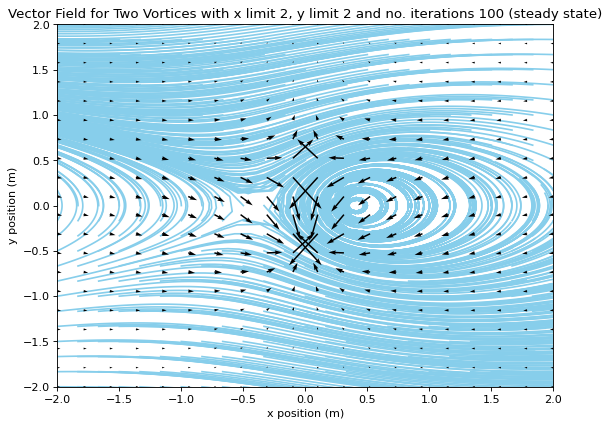

In [330]:
plotVectorField(steadyStateODEs,100,4, 2, 2,'skyblue','steady state', True)

## Investigation of Numerical Accuracy

We might want to characterise how changes in timestep alter the accuracy of results. We do so by first examining the effect of timestep on one of the orbits graphed above. We then graph different vector fields given different time steps. This is achieved by altering the iterations parameter in the function plotVectorField written above.

For the orbit we choose the second quadrant initial position $(-0.2,0.2)$ and decrease the number of iterations for $t$ thus increasing the timestep which we calculate as the total time divided by the number of iterations

### Orbit Path Accuracy

In [305]:
def plotSecondQuadrantPath(iterations, temporalLength):
    t = np.linspace(0,temporalLength,iterations)
    path = odeint(steadyStateODEs, [-0.2,0.2], t, args=(1,0.4))
    timeStep = temporalLength/iterations
    
    fig = plt.figure(figsize=(4, 3), dpi=80)
    plt.plot(path[:,0], path[:,1])
    plt.title(f"Quadrant 2 Circular Orbit with timestep {timeStep}")
    plt.xlim(-1,3)
    plt.ylim(-1,1)
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.show()

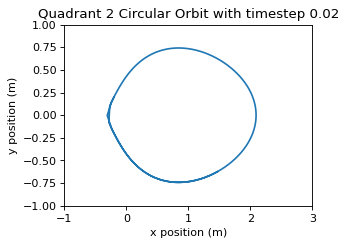

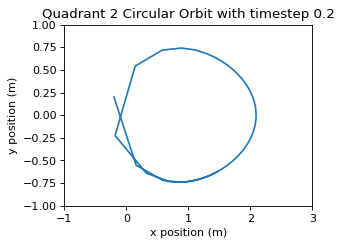

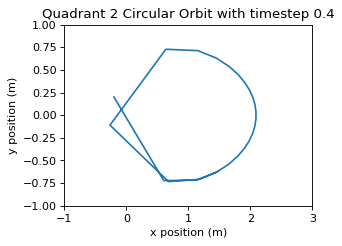

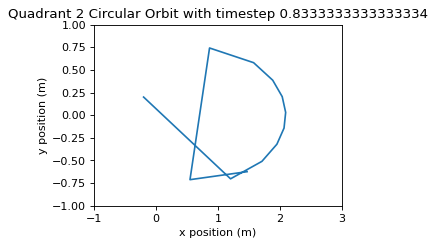

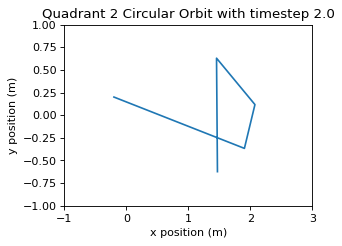

In [306]:
iterationNumbers = [500,50,25,12,5]
    
for iterationNumber in iterationNumbers:
    plotSecondQuadrantPath(iterationNumber,10)

As we can see as the time step increases, the accuracy of results appears to go down. This is because the ODE solver recursively calculates the next position by using that of the previous. I.e. the solver is memoryless. The new position is entirely based on the old, and the temporal distance between these points is given by the timestep. If the step is large, one does not stay on a singular path, rather, varying between many distinct paths in the vector field.

### Vector Field Accuracy

/Users/jackmiller/miniforgeRosetta/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


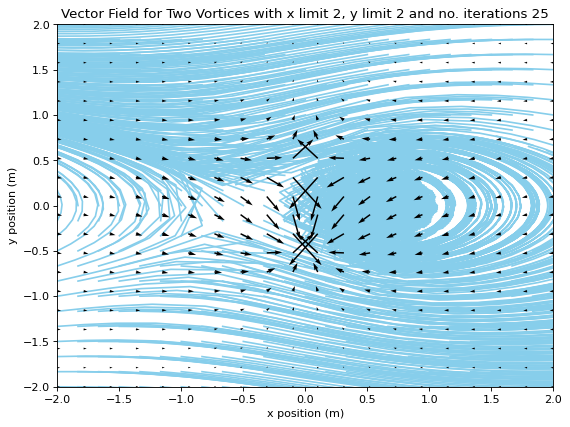

/Users/jackmiller/miniforgeRosetta/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


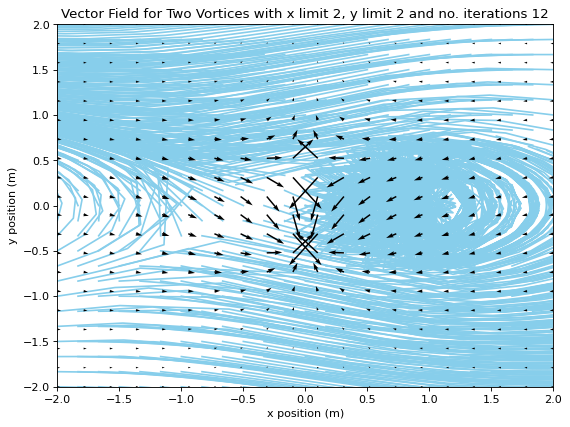

/Users/jackmiller/miniforgeRosetta/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


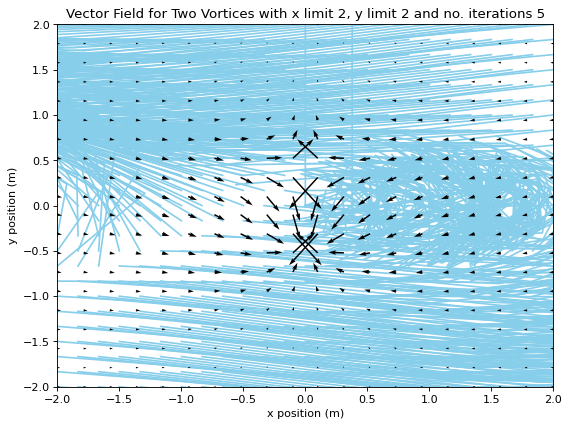

In [307]:
for iterationNumber in iterationNumbers[2:]:
    plotVectorField(iterationNumber,10, 2, 2)

Since the vectors are calculated independently of the paths they don't change, however, we can see that the paths most certainly do. Indeed, detail in the region left of the two vortices decreases drastically and the well defined gaps seen on the structure on the right disappear.

## Blinking Vortices

In order to implement the equations for blinking vortices we add time dependence to the beta parameter in our equations and remove the secondary terms. As such they appear:

$$u(x,y,t) = \frac{- \alpha y}{\left(x-\beta\right)^2 + y^2}$$

$$v(x,y,t) = \frac{\alpha \left(x-\beta\right)}{\left(x-\beta\right)^2 + y^2}$$

$$\beta(t) = \beta_0 \text{sign}\left(\sin(2 \pi t)\right)$$

This beta term acts to alternatively turn the left and right vortices off and on.

In [317]:
# We define the time depdent ODEs with the parameters alpha and alpha_0
def chaoticODEs(diff_array,t,alpha,beta_0):
    x = diff_array[0]
    y = diff_array[1]
    
    # Inclusion of time dependent beta
    beta = beta_0 * np.sign(np.sin(2*np.pi*t))
    
    # These equations are as above
    u = (- alpha * y)/((x-beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2)
    
    return [u, v]

We now solve this equation for the initial conditions of the quadrant 2 orbital path to get an indication as to behaviour. We also map the vector field within a time frame that allows for blinking to see what that will look like.

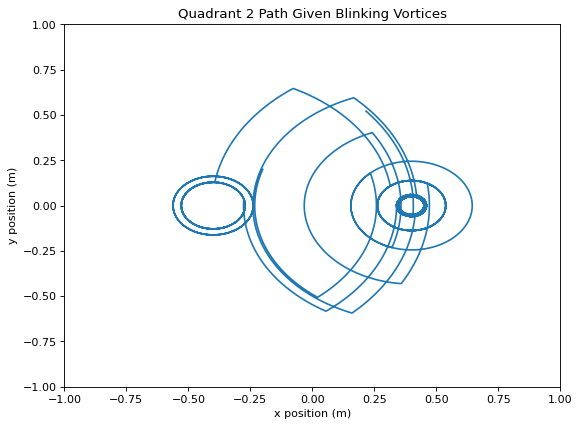

In [318]:
t = np.linspace(0,10,5000)

path = odeint(chaoticODEs, [-0.2,0.2], t, args=(1,0.4))

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(path[:,0], path[:,1])
plt.title("Quadrant 2 Path Given Blinking Vortices")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.show()

(need to provide some description here...)

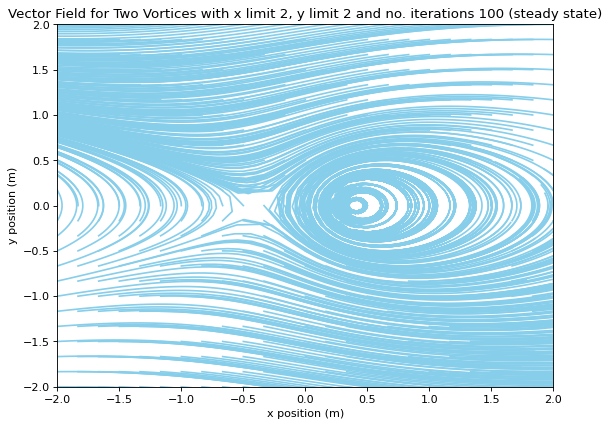

/var/folders/19/h2rjx12n1_9_sg603hljkxw00000gn/T/ipykernel_6977/2200691666.py:10: RuntimeWarning: invalid value encountered in double_scalars
  u = (- alpha * y)/((x-beta)**2 + y**2)
/var/folders/19/h2rjx12n1_9_sg603hljkxw00000gn/T/ipykernel_6977/2200691666.py:11: RuntimeWarning: invalid value encountered in double_scalars
  v = (alpha * (x-beta))/((x-beta)**2 + y**2)


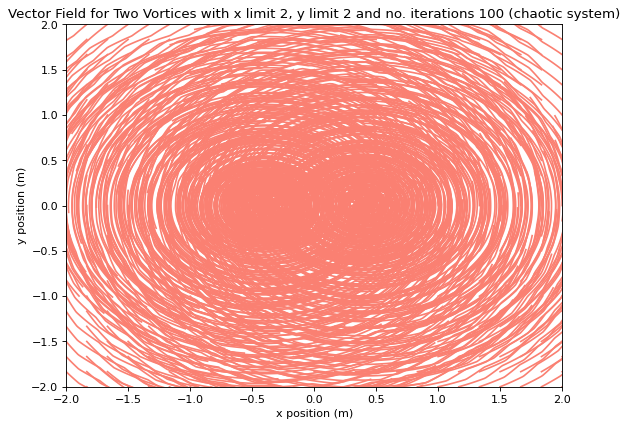

In [331]:
plotVectorField(steadyStateODEs,100,4, 2, 2,'skyblue','steady state', False)
plotVectorField(chaoticODEs,100,4, 2, 2, 'salmon', 'chaotic system', False)

(need to provide some description here...)